# **PyCaret**


PyCaret es una biblioteca de código abierto de aprendizaje automático (machine learning) para Python que facilita y agiliza el proceso de desarrollo y experimentación con modelos de aprendizaje automático. Fue desarrollado para simplificar tareas comunes en el flujo de trabajo de aprendizaje automático, como la preparación de datos, la selección de características, la creación de modelos, la evaluación y comparación de modelos, y la interpretación de resultados.

Las características principales de PyCaret son:

* Interfaz sencilla: PyCaret proporciona una interfaz de línea de comandos simple e intuitiva, lo que lo hace accesible incluso para usuarios nuevos en aprendizaje automático.

* Automatización del flujo de trabajo: PyCaret automatiza muchas de las tareas repetitivas y tediosas que generalmente se realizan en el proceso de desarrollo de modelos, lo que permite a los usuarios centrarse más en la experimentación y la iteración rápida.

* Soporte para múltiples bibliotecas de aprendizaje automático: PyCaret es compatible con varias bibliotecas populares de aprendizaje automático, como scikit-learn, XGBoost, LightGBM, CatBoost, etc. Esto permite a los usuarios comparar fácilmente diferentes algoritmos sin necesidad de escribir mucho código.

* Funciones de preprocesamiento de datos: PyCaret ofrece funcionalidades para la preparación y limpieza de datos, incluyendo manejo de valores faltantes, codificación de variables categóricas, y más.

* Comparación de modelos: PyCaret permite comparar rápidamente el rendimiento de varios modelos utilizando diferentes métricas, lo que ayuda a seleccionar el mejor modelo para un problema en particular.

* Sintonización automática de hiperparámetros: PyCaret puede realizar automáticamente la búsqueda de hiperparámetros para optimizar los modelos, lo que reduce la necesidad de ajustar manualmente los hiperparámetros.

* Interpretación de modelos: PyCaret ofrece funciones para interpretar y visualizar los modelos entrenados, lo que facilita la comprensión de cómo funcionan y qué características son más importantes para la predicción.

En general, PyCaret es una excelente herramienta para acelerar y simplificar el proceso de desarrollo de modelos de aprendizaje automático, lo que lo hace especialmente útil para usuarios que deseen experimentar con diferentes algoritmos y técnicas de manera eficiente. Sin embargo, es importante tener en cuenta que, como en cualquier biblioteca de alto nivel, la flexibilidad y control sobre el flujo de trabajo pueden ser más limitados que al utilizar bibliotecas de nivel más bajo como scikit-learn.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # Dividir la data en entraniemo y prueba
import statsmodels.api as sms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn import metrics
from skopt import BayesSearchCV
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pycaret
from pycaret.classification import *

import xgboost as xgb
import lightgbm as lgb
import catboost 




import warnings
warnings.filterwarnings("ignore")


def MetricasMatrizConfusion(y,Modelo,X,tipo="ML"):
    ## Validar la longitud de los datos
    if (len(y)==len(X)):
        
        if (tipo!="ML"):
            Probabilidad=Modelo.predict(exog=X) # Logit
            Predicciones=np.where(Probabilidad<0.5,0,1)
        else:
            Predicciones=Modelo.predict(X) # Modleo de ML    
        td1=pd.DataFrame(Predicciones,columns=["Predicciones"])
        td2=pd.concat([y.reset_index(drop=True),td1],axis=1)
        td2.columns=["Realidad","Predicciones"]
        Matriz=pd.crosstab(td2["Realidad"],td2["Predicciones"],margins=True)
        
        ## Formato porcentaje
        MatrizNormalizada=pd.crosstab(td2["Realidad"],td2["Predicciones"],normalize=0)
        sns.heatmap(MatrizNormalizada,annot=True,linewidths = 0.01, cmap = "Blues")
        
        ### Métricas, Recall, Precisión
        
        Accuracy =metrics.accuracy_score(y,Predicciones)
        print(f'Accuracy: {Accuracy}')
        Reporte=metrics.classification_report(y,Predicciones)
        print(f'Reporte : {Reporte}')
        
    
    
    else:
        
        Matriz=[]
        print("Los datos no tienen la misma longitud")
    
    
    return Matriz

def curva_roc(y,Modelo,X,tipo="ML"):
    if (tipo!="ML"):
        Probabilidad=Modelo.predict(exog=X) # Logit (statsmodels)
    else:
        Probabilidad=Modelo.predict_proba(X)[:,1] # cuando es Machine Learning(SKlearn) 
        
    roc_auc=roc_auc_score(y,Probabilidad)
    false_positive,true_positive,limites=roc_curve(y,Probabilidad)
    ramdom_probs=[0 for i in range(len(y))]
    c,d,_=roc_curve(y,ramdom_probs,pos_label=1) ## Diagonal
    
    plt.plot(false_positive,true_positive,linestyle="--",color="green",label="AUC: "+str(round(roc_auc,2)))
    plt.plot(c,d,linestyle="--",color="blue")
    plt.xlabel("Tasa Falsos Positivos")
    plt.ylabel("Tasa Verdaderos Positivos")
    plt.legend()
    plt.show()
    return roc_auc

In [2]:
## Anaconda 
# conda install -c conda-forge pycaret [full]
# conda install -c conda-forge lightgbm
# conda install -c conda-forge catboost
# onda install -c conda-forge xgboost
# conda install -c conda-forge scikit-optimize

In [3]:
## Google colab
# !pip install pycaret[full]
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install scikit-optimize

## **Preparar los datos**

In [4]:
df=pd.read_csv("BaseModelos.csv")

In [5]:
df.head()

,MontoCredito,Edad,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0_-1,...,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,Genero_Homologado_Masculino,EducacionHomologada_Posgrado,EducacionHomologada_Pregrado,EstadoCivilHomologado_Otros,EstadoCivilHomologado_Soltero,Mora
0,20000.0,24.0,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,1,0,1,0,0,1
1,120000.0,26.0,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,...,0,0,0,0,1,0,1,0,1,1
2,90000.0,34.0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,...,0,0,0,0,1,0,1,0,1,0
3,50000.0,37.0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,...,0,0,0,0,1,0,1,0,0,0
4,50000.0,57.0,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1,...,0,0,0,0,0,0,1,0,0,0


In [6]:
Cat_Chi2=pd.read_csv("CatSignificativasChi2.csv")["Variable"].tolist()
Num_Anova=pd.read_csv("NumericasSignificativasAnova.csv")["Variable"].tolist()

In [7]:
VariablesPredictivas=Cat_Chi2+Num_Anova

In [8]:
X=df[VariablesPredictivas]

In [9]:
y=df[["Mora"]]

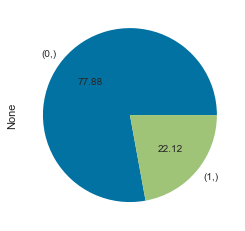

In [10]:
y.value_counts().plot(kind="pie",autopct="%.2f");

In [11]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123, stratify=y)

In [12]:
y_train.value_counts(normalize=True)

Mora
0       0.77881
1       0.22119
dtype: float64

In [13]:
y_test.value_counts(normalize=True)

Mora
0       0.778778
1       0.221222
dtype: float64

## **Configuración Pycaret**

In [14]:
pycaret_train=pd.concat([x_train,y_train],axis=1)
pycaret_test=pd.concat([x_test,y_test],axis=1)

In [15]:
Model=setup(data=pycaret_train,test_data=pycaret_test,target="Mora",session_id=123,fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,Mora
2,Target type,Binary
3,Original data shape,"(30000, 64)"
4,Transformed data shape,"(41710, 64)"
5,Transformed train set shape,"(32710, 64)"
6,Transformed test set shape,"(9000, 64)"
7,Numeric features,63
8,Preprocess,True
9,Imputation type,simple


In [16]:
models_to_compare=["rf",'lightgbm','xgboost',"dt","catboost","gbc","lr","et"]

In [17]:
best_model=compare_models(include=models_to_compare,fold=5,sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8179,0.7752,0.3653,0.6597,0.4702,0.3710,0.3947,5.5980
lightgbm,Light Gradient Boosting Machine,0.8185,0.7728,0.3722,0.6590,0.4756,0.3760,0.3985,0.6940
catboost,CatBoost Classifier,0.8168,0.7714,0.3791,0.6467,0.4779,0.3759,0.3957,9.6980
rf,Random Forest Classifier,0.8131,0.7577,0.3804,0.6280,0.4738,0.3684,0.3855,2.1620
xgboost,Extreme Gradient Boosting,0.8090,0.7553,0.3612,0.6168,0.4556,0.3492,0.3677,3.7340
et,Extra Trees Classifier,0.8025,0.7384,0.3750,0.5833,0.4565,0.3428,0.3553,1.5220
lr,Logistic Regression,0.5449,0.6381,0.7107,0.2867,0.4085,0.1363,0.1739,0.3020
dt,Decision Tree Classifier,0.7211,0.6130,0.4181,0.3812,0.3987,0.2177,0.2182,0.8220


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

In [19]:
#stop

In [ ]:
#plot_model(best_model, plot = 'auc')

**Seleccionamos Modelo**

In [20]:
best_model=create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8105,0.7849,0.3685,0.6196,0.4622,0.3560,0.3737
1,0.8252,0.7840,0.3750,0.6932,0.4867,0.3925,0.4194
2,0.8133,0.7722,0.3578,0.6385,0.4586,0.3564,0.3783
3,0.8071,0.7476,0.3254,0.6214,0.4272,0.3246,0.3491
4,0.8200,0.7797,0.3642,0.6706,0.4721,0.3748,0.4002
5,0.8214,0.7645,0.3828,0.6692,0.4870,0.3885,0.4107
6,0.8119,0.7761,0.3484,0.6378,0.4506,0.3487,0.3720
7,0.8248,0.7984,0.3849,0.6858,0.4931,0.3971,0.4214
8,0.8238,0.7855,0.3677,0.6923,0.4803,0.3860,0.4141


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
#plot_model(best_model,plot="learning")

In [22]:
#plot_model(best_model,plot="feature")

# **La optimización bayesiana**


La optimización bayesiana es un enfoque de optimización que se basa en la inferencia bayesiana y la probabilidad para encontrar la configuración óptima de parámetros de un sistema o función objetivo desconocida. Este enfoque es particularmente útil cuando la evaluación de la función objetivo es costosa o requiere mucho tiempo.

La idea fundamental detrás de la optimización bayesiana es construir un modelo probabilístico de la función objetivo y utilizar este modelo para guiar la búsqueda de la configuración óptima de los parámetros. A medida que se evalúan diferentes configuraciones, el modelo se actualiza con la nueva información, lo que mejora gradualmente la calidad de las predicciones y la búsqueda de la configuración óptima.

In [23]:
tuned_best_model=tune_model(best_model,search_library="scikit-optimize",return_train_score=True,
                           fold=3,choose_better=True,optimize="AUC",n_iter=2)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [24]:
tuned_best_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
#plot_model(tuned_best_model,plot="learning")

**Entrenamos de forma independiente**

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
ModeloFinal=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [28]:
ModeloFinal.fit(x_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy: 0.8261904761904761
Reporte :               precision    recall  f1-score   support

           0       0.84      0.96      0.90     16355
           1       0.70      0.37      0.49      4645

    accuracy                           0.83     21000
   macro avg       0.77      0.66      0.69     21000
weighted avg       0.81      0.83      0.80     21000



Predicciones,0,1,All
Realidad,,,
0,15624,731,16355
1,2919,1726,4645
All,18543,2457,21000


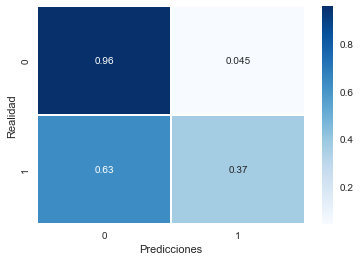

In [29]:
MetricasMatrizConfusion(y=y_train,Modelo=ModeloFinal,X=x_train,tipo="ML")

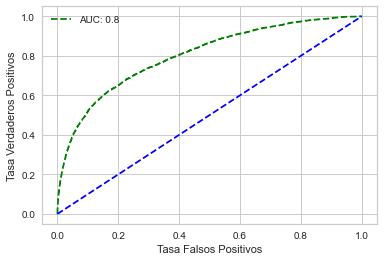

0.802133923749794

In [30]:
curva_roc(y=y_train,Modelo=ModeloFinal,X=x_train,tipo="ML")

Accuracy: 0.822
Reporte :               precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.69      0.36      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.66      0.68      9000
weighted avg       0.81      0.82      0.80      9000



Predicciones,0,1,All
Realidad,,,
0,6684,325,7009
1,1277,714,1991
All,7961,1039,9000


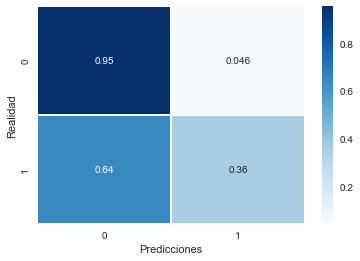

In [31]:
MetricasMatrizConfusion(y=y_test,Modelo=ModeloFinal,X=x_test,tipo="ML")

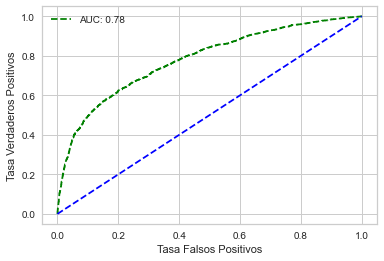

0.7799288551943583

In [32]:
curva_roc(y=y_test,Modelo=ModeloFinal,X=x_test,tipo="ML")

## **Exportar Modelo**

In [33]:
import pickle

In [34]:
with open('ModeloFinalCredit.pkl', 'wb') as file:
    pickle.dump(ModeloFinal, file)

## **Presentación Empresa**